# Wasserstein-like WGAN - Conditional WGAN-GP

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# === Load and preprocess dataset ===
df = pd.read_csv('input/ML_data.csv')
print(f"Original dataset shape: {df.shape}")

# Drop the Samples column (as it's an identifier)
df = df.drop(columns=['Samples'])

print(f"Cell types: {df['Cell_type'].unique()}")

# Filter out the rows where 'Cell_type' is in the unwanted list
unwanted_cell_types = ['Unknown']
df = df[~df['Cell_type'].isin(unwanted_cell_types)]
print(f"Cell types: {df['Cell_type'].unique()}")

# Encode the 'Cell_type' labels
le = LabelEncoder()
df['Cell_type'] = le.fit_transform(df['Cell_type'])

# Save for decoding later
label_names = le.classes_


# Normalize the feature columns
scaler = MinMaxScaler()
feature_columns = df.columns[:-1]  # All columns except 'Cell_type'
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Convert to PyTorch tensors
data = torch.tensor(df.values, dtype=torch.float32)

# Separate the features and labels
X = data[:, :-1]  # All columns except the last one (features)
y = data[:, -1].long()  # The last column (target labels), ensuring they are of type long for classification


# Check for unique labels
print(f"Features shape: {X.shape}")
print(f"Unique labels: {torch.unique(y)}")

# Create a DataLoader
batch_size = 64  # Adjust as needed
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check for NaNs or Infs in the data
if torch.isnan(data).any() or torch.isinf(data).any():
    print("Data contains NaNs or Infs")


Original dataset shape: (766, 91)
Cell types: ['PreB' 'PreT' 'T' 'B' 'Unknown']
Cell types: ['PreB' 'PreT' 'T' 'B']
Features shape: torch.Size([742, 89])
Unique labels: tensor([0, 1, 2, 3])


## cWGAN-GP

In [14]:
# === Hyperparameters ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Model Definitions ===
data_dim = X.shape[1]  # Number of features in your dataset
noise_dim = 128  # Latent space dimension
label_dim = len(torch.unique(y))  # Number of unique labels in 'Cell_type'

print(f"Data dimension: {data_dim}")
print(f"Label dimension: {label_dim}")

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),  # Increased units for better representation
            nn.LeakyReLU(0.2),  # LeakyReLU instead of ReLU to avoid dead neurons
            nn.BatchNorm1d(128),  # Batch Normalization for better stability
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, data_dim),
            nn.Tanh()  # Output activation to ensure range [-1, 1]
        )
    
    def forward(self, z, labels):
        return self.net(torch.cat((z, labels), dim=1))


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim + label_dim, 128),  # Increased units for better representation
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1)  # No activation at the end of Critic for real-valued output
        )
    
    def forward(self, x, labels):
        return self.net(torch.cat((x, labels), dim=1))


# Inversion network
class InversionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(data_dim + label_dim, noise_dim)

    def forward(self, x, labels):
        return self.fc(torch.cat((x, labels), dim=1))

# === Utility functions ===
def one_hot(labels, num_classes=label_dim):
    return torch.nn.functional.one_hot(labels.to(torch.long), num_classes=num_classes).float()

def gradient_penalty(critic, real, fake, labels):
    # Make sure tensors have the same size
    batch_size = min(real.size(0), fake.size(0))
    if real.size(0) != fake.size(0):
        real = real[:batch_size]
        fake = fake[:batch_size]
        labels = labels[:batch_size]
        
    alpha = torch.rand(batch_size, 1).to(device)
    alpha = alpha.expand_as(real)
    inter = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    
    inter_out = critic(inter, labels)
    
    grads = torch.autograd.grad(
        outputs=inter_out, inputs=inter,
        grad_outputs=torch.ones_like(inter_out),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    
    grads = grads.view(grads.size(0), -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    
    return gp

def plot_generated_vs_real(G, dataloader, noise_dim, label_dim, device, method="pca", num_samples=1000, label_names=None):
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import numpy as np

    G.eval()
    real_samples, real_labels_all = [], []
    fake_samples, fake_labels_all = [], []

    with torch.no_grad():
        for real_data, real_labels in dataloader:
            batch_size = real_data.size(0)
            if batch_size < 2:
                continue

            real_data = real_data.to(device)
            real_labels = real_labels.to(device)
            real_samples.append(real_data.cpu().numpy())
            real_labels_all.append(real_labels.cpu().numpy())

            fake_labels = torch.randint(0, label_dim, (batch_size,), device=device)
            fake_oh = one_hot(fake_labels)
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_data = G(noise, fake_oh)
            fake_samples.append(fake_data.cpu().numpy())
            fake_labels_all.append(fake_labels.cpu().numpy())

            if len(real_samples) * batch_size >= num_samples:
                break

    real = np.vstack(real_samples)
    fake = np.vstack(fake_samples)
    real_labels = np.concatenate(real_labels_all)
    fake_labels = np.concatenate(fake_labels_all)

    X = np.vstack([real, fake])
    y_source = np.array([0]*len(real) + [1]*len(fake))  # 0 = real, 1 = fake
    y_class = np.concatenate([real_labels, fake_labels])

    reducer = PCA(n_components=2)

    X_reduced = reducer.fit_transform(X)

    # Plot
    plt.figure(figsize=(7, 6))
    for source_type in [0, 1]:  # 0=real, 1=fake
        marker = 'o' if source_type == 0 else 'x'
        for c in range(label_dim):
            idx = (y_source == source_type) & (y_class == c)
            if np.sum(idx) == 0:
                continue
            label_name = label_names[c] if label_names is not None else f"Class {c}"
            plt.scatter(
                X_reduced[idx, 0],
                X_reduced[idx, 1],
                alpha=0.6,
                s=20,
                marker=marker,
                label=f"{'Real' if source_type == 0 else 'Fake'} - {label_name}"
            )

    plt.title(f"{method.upper()} Projection: Real (o) vs Fake (x), colored by class")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.close()
    


Using device: cuda
Data dimension: 89
Label dimension: 4


## Optuna tuning

In [6]:
# === Objective Function for Optuna ===
epochs = 250

def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    lambda_gp = trial.suggest_float("lambda_gp", 1.0, 20.0)
    critic_iters = trial.suggest_int("critic_iters", 5, 15)

    # Models & optimizers
    G = Generator().to(device)
    C = Critic().to(device)
    opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
    opt_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

    gen_losses = []

    for epoch in range(epochs):
        epoch_g_loss = 0.0
        batch_count = 0
        
        for _ in range(critic_iters):
            for real_data, real_labels in dataloader:
                # Get actual batch size
                current_batch_size = real_data.size(0)
                
                # Skip small batches
                if current_batch_size < 2:
                    continue
                
                real_data, real_labels = real_data.to(device), real_labels.to(device)
                real_oh = one_hot(real_labels)  # Will use num_classes=label_dim

                # Use the actual batch size for noise generation
                noise = torch.randn(current_batch_size, noise_dim, device=device)
                fake_labels = torch.randint(0, label_dim, (current_batch_size,), device=device)
                fake_oh = one_hot(fake_labels)
                fake_data = G(noise, fake_oh).detach()

                loss_D = C(fake_data, fake_oh).mean() - C(real_data, real_oh).mean()
                gp = gradient_penalty(C, real_data, fake_data, real_oh)
                loss_C = loss_D + lambda_gp * gp

                opt_C.zero_grad()
                loss_C.backward()
                opt_C.step()

        # Generator update - use a full batch or the actual batch size from the last iteration
        for real_data, real_labels in dataloader:  # Just to get a batch size
            current_batch_size = real_data.size(0)
            
            # Skip small batches
            if current_batch_size < 2:
                continue
                
            noise = torch.randn(current_batch_size, noise_dim, device=device)
            fake_labels = torch.randint(0, label_dim, (current_batch_size,), device=device)
            fake_oh = one_hot(fake_labels)
            fake_output = G(noise, fake_oh)
            loss_G = -C(fake_output, fake_oh).mean()

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()
            
            epoch_g_loss += loss_G.item()
            batch_count += 1
            break  # Just need one batch for the generator

        # Only report if we actually had batches
        if batch_count > 0:
            avg_g_loss = epoch_g_loss / batch_count
            gen_losses.append(avg_g_loss)
            
            # Report intermediate value for pruning
            trial.report(avg_g_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            print(f"Warning: No batches processed in epoch {epoch}")

    return sum(gen_losses) / max(1, len(gen_losses))

# Create and run the study
study = optuna.create_study(
    study_name="cWGAN_GP_hyperparam_tuning",
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
    sampler=TPESampler(seed=42)
)

# Run optimization
print("Starting optimization...")
study.optimize(objective, n_trials=25)

# Print results
print("Study finished!")
print(f"Best parameters: {study.best_params}")
print(f"Best value: {study.best_value}")

# Save best model
print("Training final model with best parameters...")
# Extract best hyperparameters
best_lr = study.best_params["lr"]
best_lambda_gp = study.best_params["lambda_gp"]
best_critic_iters = study.best_params["critic_iters"]


[I 2025-04-30 09:41:15,324] A new study created in memory with name: cWGAN_GP_hyperparam_tuning


Starting optimization...


[I 2025-04-30 09:43:49,941] Trial 0 finished with value: 0.02040391131490469 and parameters: {'lr': 5.6115164153345e-05, 'lambda_gp': 19.063571821788408, 'critic_iters': 13}. Best is trial 0 with value: 0.02040391131490469.
[I 2025-04-30 09:45:02,025] Trial 1 finished with value: -0.010790454789996146 and parameters: {'lr': 0.00015751320499779721, 'lambda_gp': 3.964354168406294, 'critic_iters': 6}. Best is trial 1 with value: -0.010790454789996146.
[I 2025-04-30 09:47:15,766] Trial 2 finished with value: 0.025848267070949078 and parameters: {'lr': 1.3066739238053272e-05, 'lambda_gp': 17.457346769723767, 'critic_iters': 11}. Best is trial 1 with value: -0.010790454789996146.
[I 2025-04-30 09:50:14,055] Trial 3 finished with value: 0.041817380979657176 and parameters: {'lr': 0.0002607024758370766, 'lambda_gp': 1.3911053916202465, 'critic_iters': 15}. Best is trial 1 with value: -0.010790454789996146.
[I 2025-04-30 09:51:34,218] Trial 4 finished with value: 0.010754258833825588 and parame

Study finished!
Best parameters: {'lr': 1.1854103172337168e-05, 'lambda_gp': 8.985559494884555, 'critic_iters': 9}
Best value: -0.04016033923625946
Training final model with best parameters...


## Loop

Epoch 0/5000, Loss G: 0.0358, Loss C: 8.9856, Loss I: 0.3927


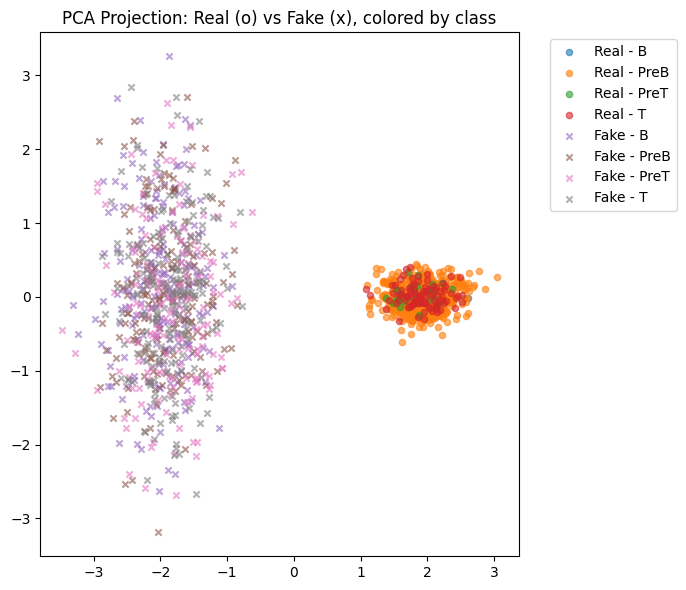

Epoch 250/5000, Loss G: 0.0358, Loss C: 8.9854, Loss I: 0.2243


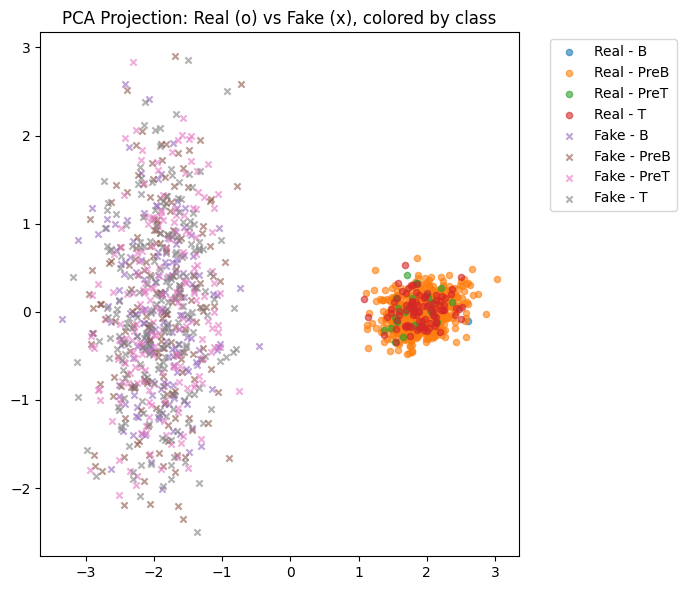

Epoch 500/5000, Loss G: 0.0358, Loss C: 8.9829, Loss I: 0.1714


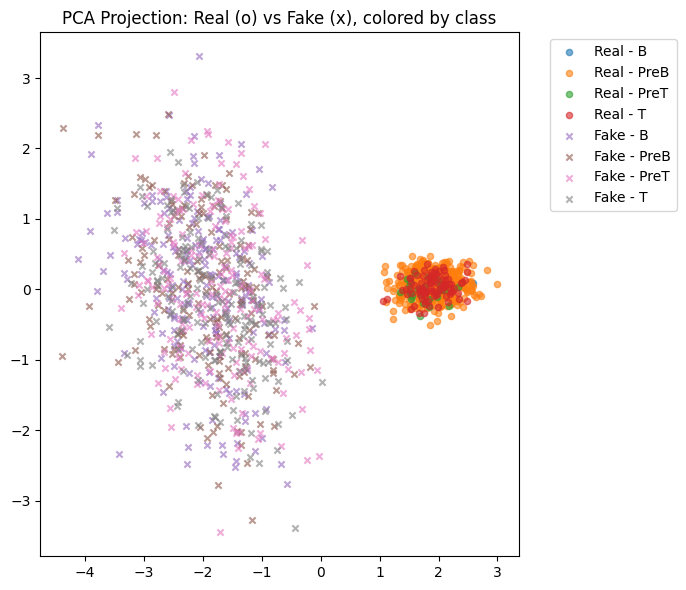

Epoch 750/5000, Loss G: 0.0358, Loss C: 8.9822, Loss I: 0.1148


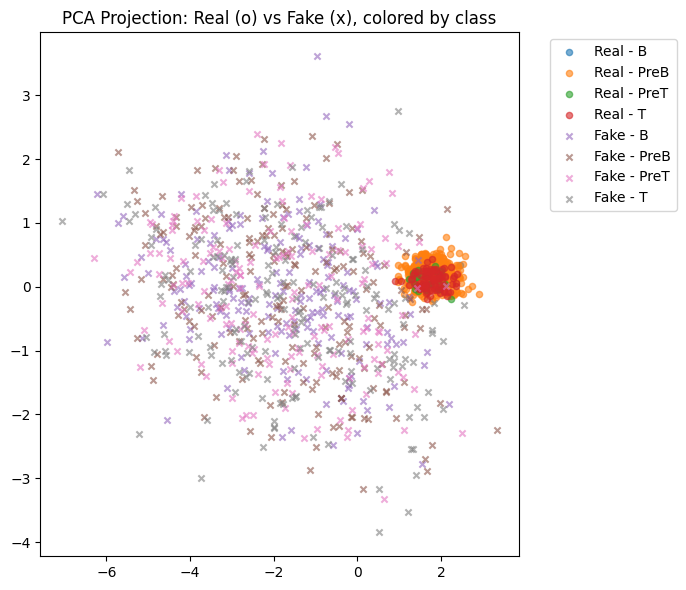

Epoch 1000/5000, Loss G: 0.0358, Loss C: 8.9767, Loss I: 0.0925


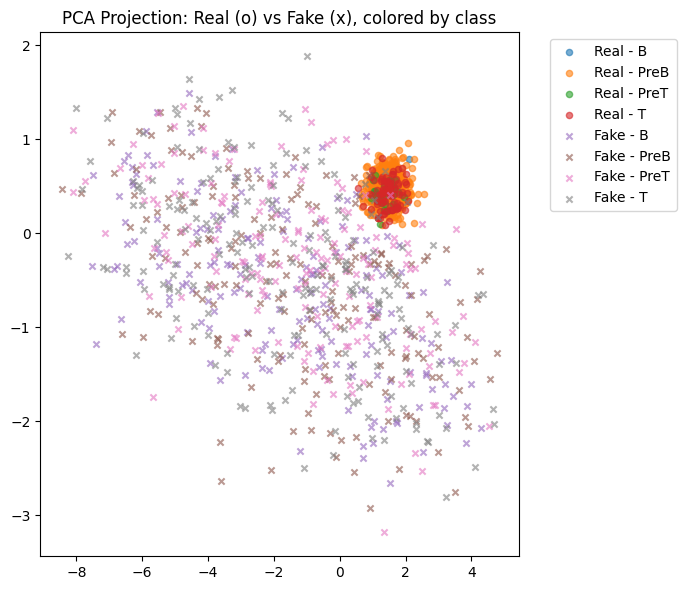

Epoch 1250/5000, Loss G: 0.0358, Loss C: 8.9819, Loss I: 0.0867


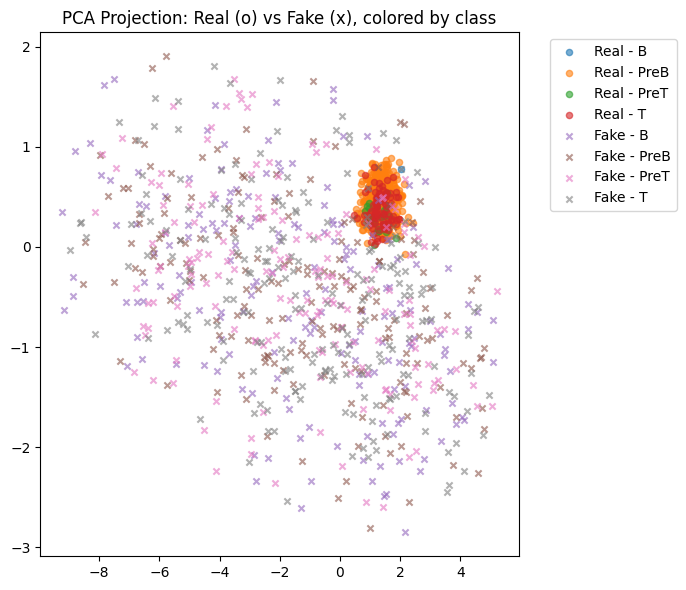

Epoch 1500/5000, Loss G: 0.0357, Loss C: 8.9648, Loss I: 0.0816


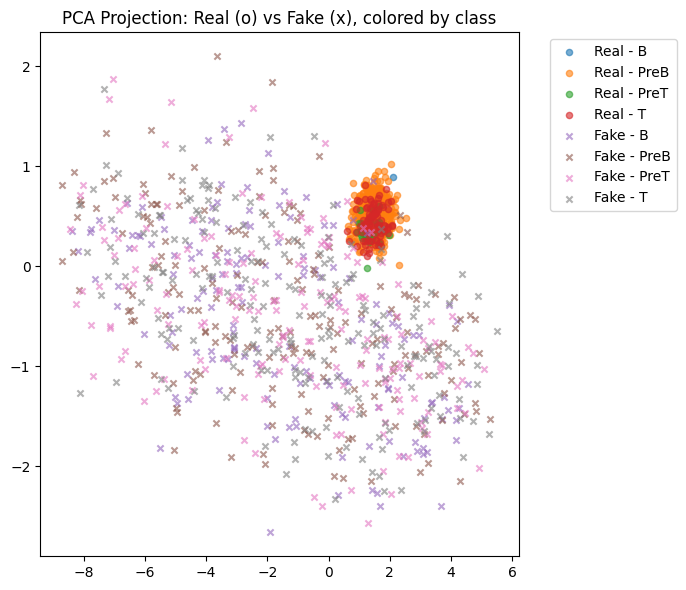

Epoch 1750/5000, Loss G: 0.0358, Loss C: 8.9611, Loss I: 0.0770


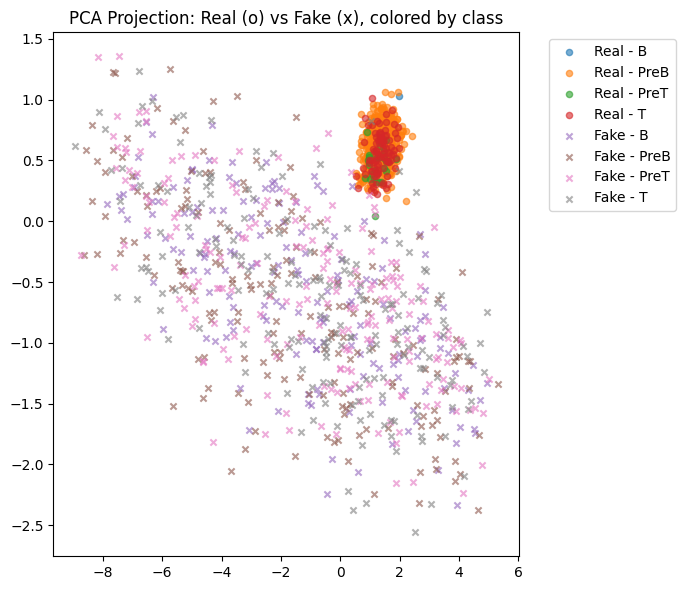

Epoch 2000/5000, Loss G: 0.0358, Loss C: 8.9751, Loss I: 0.0812


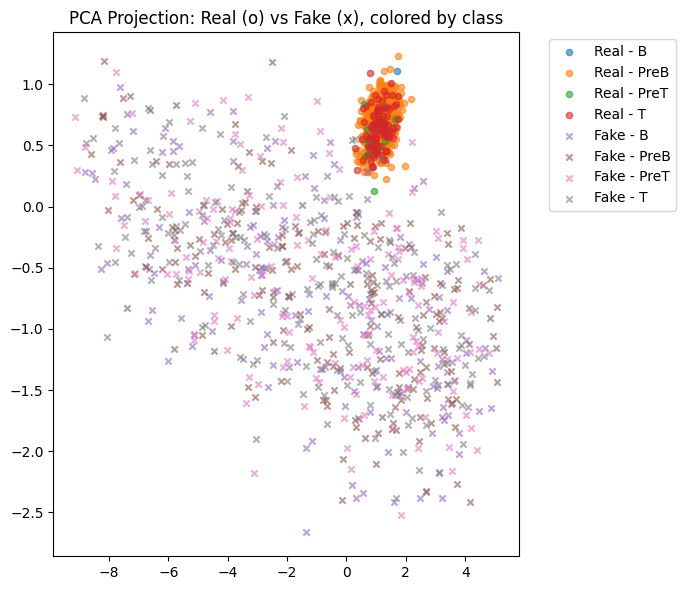

Epoch 2250/5000, Loss G: 0.0357, Loss C: 8.9844, Loss I: 0.0780


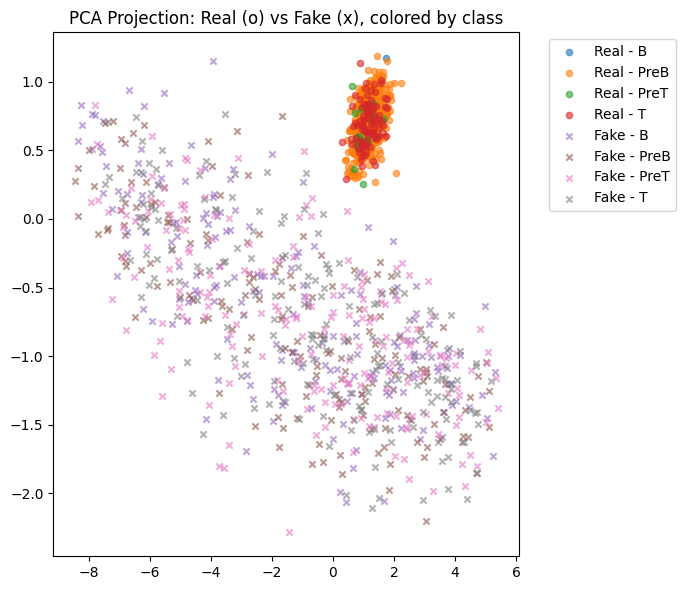

Epoch 2500/5000, Loss G: 0.0358, Loss C: 8.9778, Loss I: 0.0768


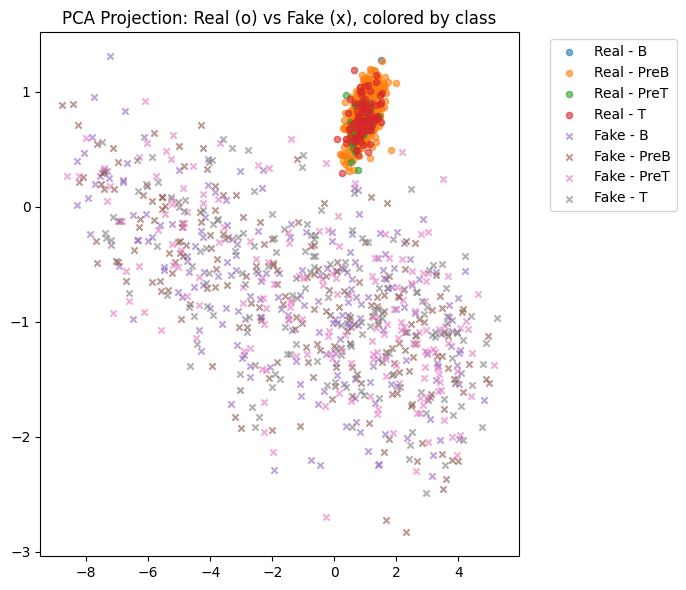

Epoch 2750/5000, Loss G: 0.0358, Loss C: 8.9800, Loss I: 0.0720


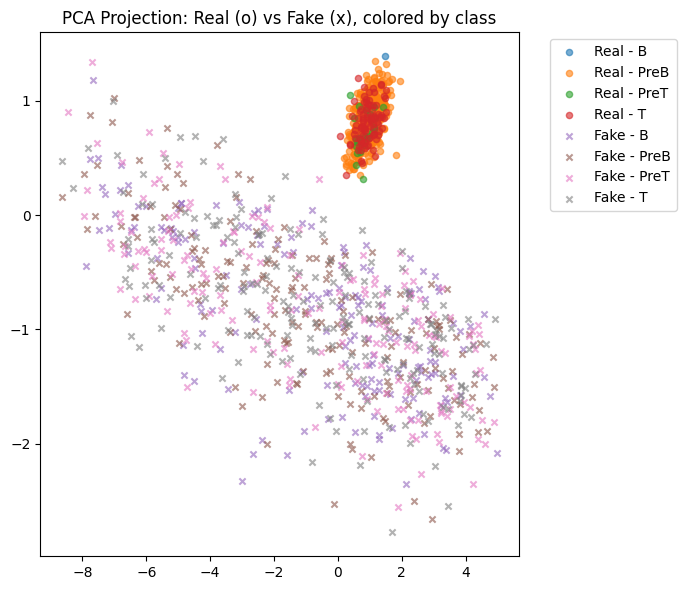

Epoch 3000/5000, Loss G: 0.0358, Loss C: 8.9771, Loss I: 0.0706


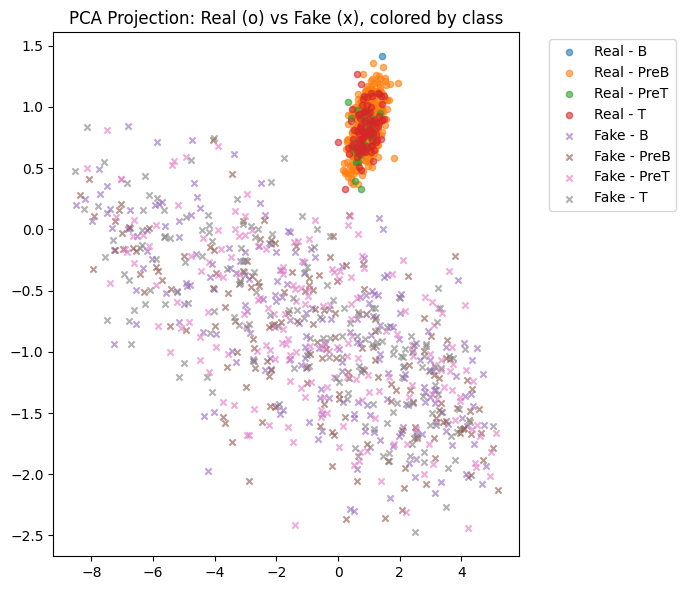

Epoch 3250/5000, Loss G: 0.0358, Loss C: 8.9691, Loss I: 0.0645


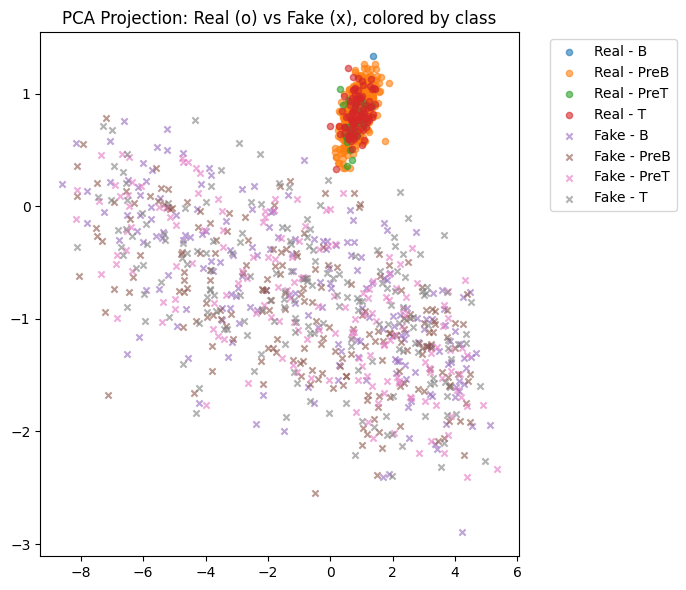

Epoch 3500/5000, Loss G: 0.0358, Loss C: 8.9718, Loss I: 0.0578


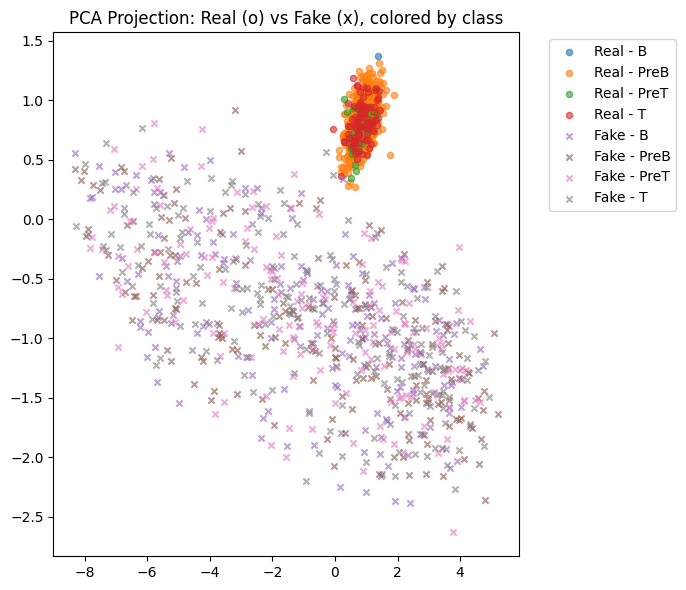

Epoch 3750/5000, Loss G: 0.0358, Loss C: 8.9546, Loss I: 0.0548


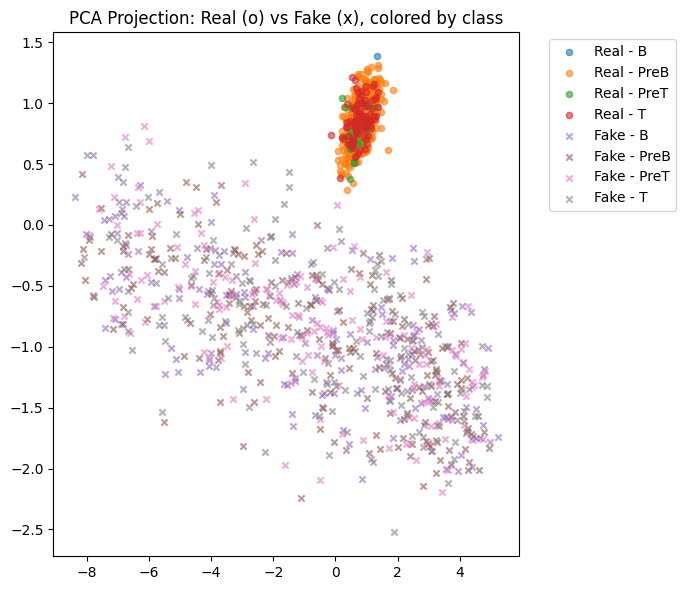

Epoch 4000/5000, Loss G: 0.0358, Loss C: 8.9803, Loss I: 0.0547


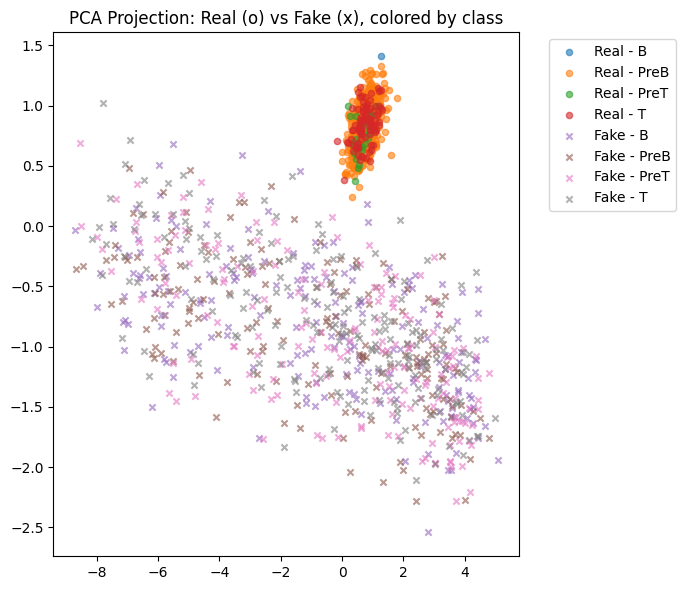

Epoch 4250/5000, Loss G: 0.0358, Loss C: 8.9793, Loss I: 0.0513


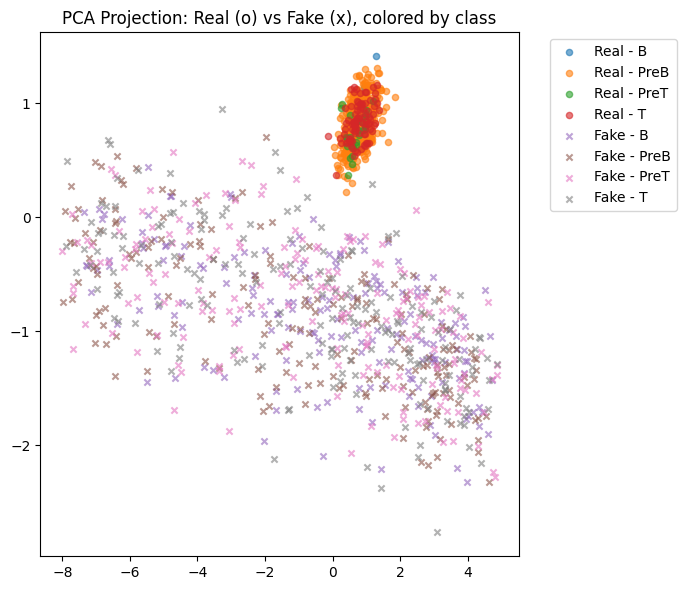

Epoch 4500/5000, Loss G: 0.0357, Loss C: 8.9444, Loss I: 0.0526


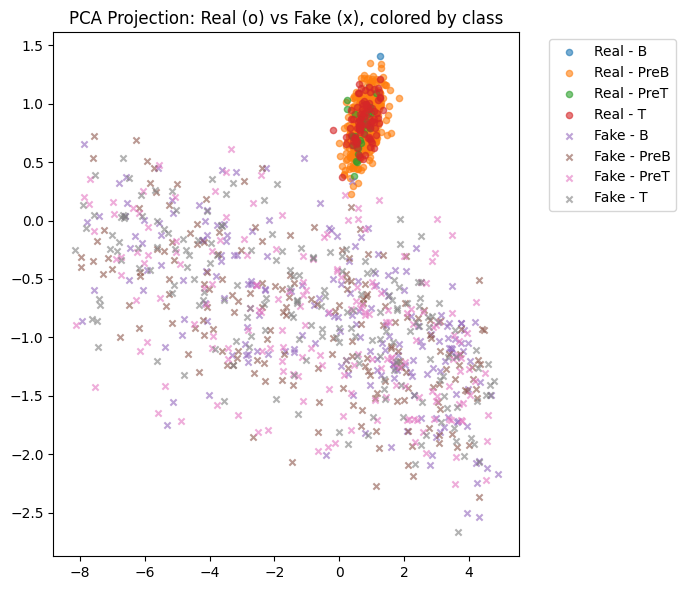

Epoch 4750/5000, Loss G: 0.0358, Loss C: 8.9852, Loss I: 0.0522


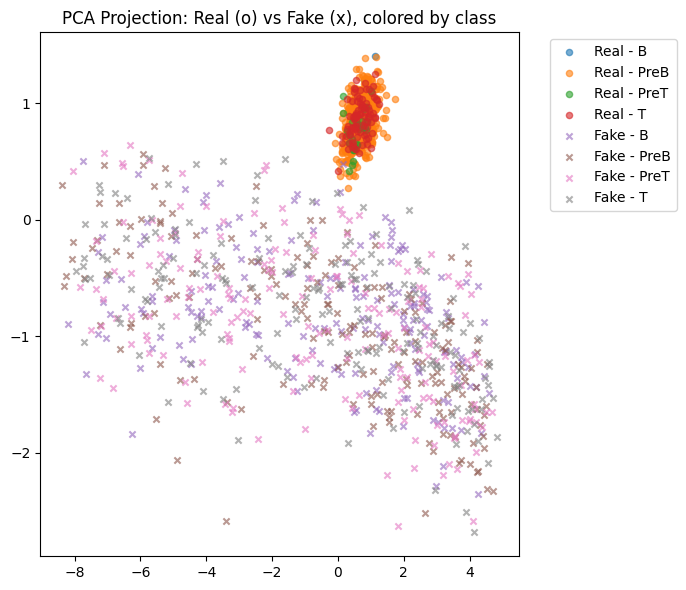

Saving models...


NameError: name 'G' is not defined

In [15]:
# Create final models
final_G = Generator().to(device)
final_C = Critic().to(device)
final_I = InversionNetwork().to(device)

# Create optimizers with best learning rate
opt_G = optim.Adam(final_G.parameters(), lr=best_lr, betas=(0.5, 0.9))
opt_C = optim.Adam(final_C.parameters(), lr=best_lr, betas=(0.5, 0.9))
opt_I = optim.Adam(final_I.parameters(), lr=best_lr, betas=(0.5, 0.9))

# Train final model (simplified version - you may want to expand this)
final_epochs = 5000
for epoch in range(final_epochs):
    # Critic training
    for _ in range(best_critic_iters):
        for real_data, real_labels in dataloader:
            current_batch_size = real_data.size(0)
            if current_batch_size < 2:
                continue
                
            real_data, real_labels = real_data.to(device), real_labels.to(device)
            real_oh = one_hot(real_labels)
            
            noise = torch.randn(current_batch_size, noise_dim, device=device)
            fake_labels = torch.randint(0, label_dim, (current_batch_size,), device=device)
            fake_oh = one_hot(fake_labels)
            fake_data = final_G(noise, fake_oh).detach()
            
            loss_D = final_C(fake_data, fake_oh).mean() - final_C(real_data, real_oh).mean()
            gp = gradient_penalty(final_C, real_data, fake_data, real_oh)
            loss_C = loss_D + best_lambda_gp * gp
            
            opt_C.zero_grad()
            loss_C.backward()
            opt_C.step()
    
    # Generator training
    for real_data, real_labels in dataloader:
        current_batch_size = real_data.size(0)
        if current_batch_size < 2:
            continue
            
        noise = torch.randn(current_batch_size, noise_dim, device=device)
        fake_labels = torch.randint(0, label_dim, (current_batch_size,), device=device)
        fake_oh = one_hot(fake_labels)
        fake_output = final_G(noise, fake_oh)
        loss_G = -final_C(fake_output, fake_oh).mean()

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # Inversion
        real_data, real_labels = real_data.to(device), real_labels.to(device)
        real_oh = one_hot(real_labels)
        pred_z = final_I(real_data, real_oh)
        reconstructed = final_G(pred_z, real_oh)
        loss_I = torch.mean((reconstructed - real_data) ** 2)

        opt_I.zero_grad()
        loss_I.backward()
        opt_I.step()

        
        break  # Just one batch for G and I
        
    # Print progress every 250 epochs
    if epoch % 250 == 0:
        print(f"Epoch {epoch}/{final_epochs}, Loss G: {loss_G.item():.4f}, Loss C: {loss_C.item():.4f}, Loss I: {loss_I.item():.4f}")
        plot_generated_vs_real(final_G, dataloader, noise_dim, label_dim, device, method="pca", label_names=label_names)



# Save models
print("Saving models...")
# Save best Generator
torch.save(G.state_dict(), "models/best_generator.pth")

# To load it later:
G_loaded = Generator().to(device)
G_loaded.load_state_dict(torch.load("models/best_generator.pth"))
G_loaded.eval()

torch.save(final_G.state_dict(), 'generator.pth')
torch.save(final_C.state_dict(), 'critic.pth')
torch.save(final_I.state_dict(), 'inverter.pth')

print("Training complete!")

In [5]:
# Save models
print("Saving models...")
torch.save(final_G.state_dict(), 'generator.pth')
torch.save(final_C.state_dict(), 'critic.pth')
torch.save(final_I.state_dict(), 'inverter.pth')

Saving models...
